Import things


In [ ]:
!ls

sample_data  training.1600000.processed.noemoticon.csv


In [1]:
import os
import sys
import numpy as np
import matplotlib as plt
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,MaxPooling1D, Input,Dropout,Flatten,Conv1D
from keras.models import Sequential
from keras import Model
import keras
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import nltk
import string

Load Data

In [7]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1")
data.columns = ["Target","ID","Date","NO_QUERY","User","Text"]
data = data[['Text','Target']]
print(data[ data['Target'] == 0].size)
print(data[ data['Target'] == 4].size)

1599998
1600000


Function to clean a given piece of text

In [8]:
data = data.sample(frac=1).reset_index(drop=True)

In [9]:
data

,Text,Target
0,@JavaJunky Whatever. I went back and forth wit...,0
1,@adambeckah I wan chinese too!!,0
2,@simon_g83 Simon it's been far too long Fi sa...,0
3,Why my mother dislikes me soo much ill never k...,0
4,@serenityfilm aw. Poor you. -Just.,0
...,...,...
1599994,@MarieDenee I'm good! Preparing for some thin...,0
1599995,@Tatterededges you've got my sort of luck - I ...,0
1599996,@JurieOnGames: yeah it looks like youtube is d...,0
1599997,Sushi for lunch... YES!,4


In [10]:
def clean(text):
    #very simple text cleaning; simply lowercases and removes punctuation
    cleaned = "".join(c for c in text if c not in string.punctuation)
    return cleaned.lower().replace("\n", " ")

In [11]:
data["Text"]=data["Text"].map(clean)

Tokenize the text data

In [12]:
embed_dim = 100
seq_length = 100
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Text'].values)
X = tokenizer.texts_to_sequences(data['Text'].values)
X = pad_sequences(X, padding = "post",truncating="post",maxlen = seq_length)
Y = data["Target"].values

In [13]:
Y = data["Target"].values

In [ ]:
def max_length(lines):
	return max([len(s.split()) for s in lines])

In [ ]:
max_length(data["Text"].values)

In [ ]:
Y

In [14]:
Y = Y/4

In [15]:
np.unique(Y)

array([0., 1.])

Build the model

In [4]:
embed_dim = 100
seq_length = 100
max_features = 100000

In [ ]:
model = 0

In [29]:
inputs1 = Input(shape=(seq_length,))
embedding1 = Embedding(max_features, embed_dim,input_length=seq_length)(inputs1)

conv1 = Conv1D(filters=100, kernel_size=2,padding="same")(embedding1)
maxpool1 = tf.keras.layers.GlobalMaxPool1D()(conv1)
flat1 = Flatten()(maxpool1)

conv2 = Conv1D(filters=100, kernel_size=4,padding="same")(embedding1)
maxpool2 = tf.keras.layers.GlobalMaxPool1D()(conv2)
flat2 = Flatten()(maxpool2)

conv3 = Conv1D(filters=50, kernel_size=6,padding="same")(embedding1)
maxpool3 = tf.keras.layers.GlobalMaxPool1D()(conv3)
flat3 = Flatten()(maxpool3)

#conv4 = Conv1D(filters=8, kernel_size=8,padding="same")(embedding1)
#maxpool4 = tf.keras.layers.AveragePooling1D(pool_size=2)(conv4)
#flat4 = Flatten()(maxpool4)

#print(maxpool1.shape)
#drop1 = Dropout(0.2)(conv1)

concat = tf.keras.layers.Concatenate()([flat1,flat2,flat3])
#flat1 = tf.keras.layers.GlobalMaxPooling1D()(concat)
#flat1 = tf.keras.layers.Flatten()(concat)
dropout1 = Dropout(0.2)(concat)
x = Dense(128)(dropout1)
x = Dropout(0.2)(x)
x = Dense(64)(x)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs=inputs1, outputs=outputs)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 100)     10000000    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 100, 100)     20100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 100, 100)     40100       embedding_2[0][0]                
_______________________________________________________________________________________

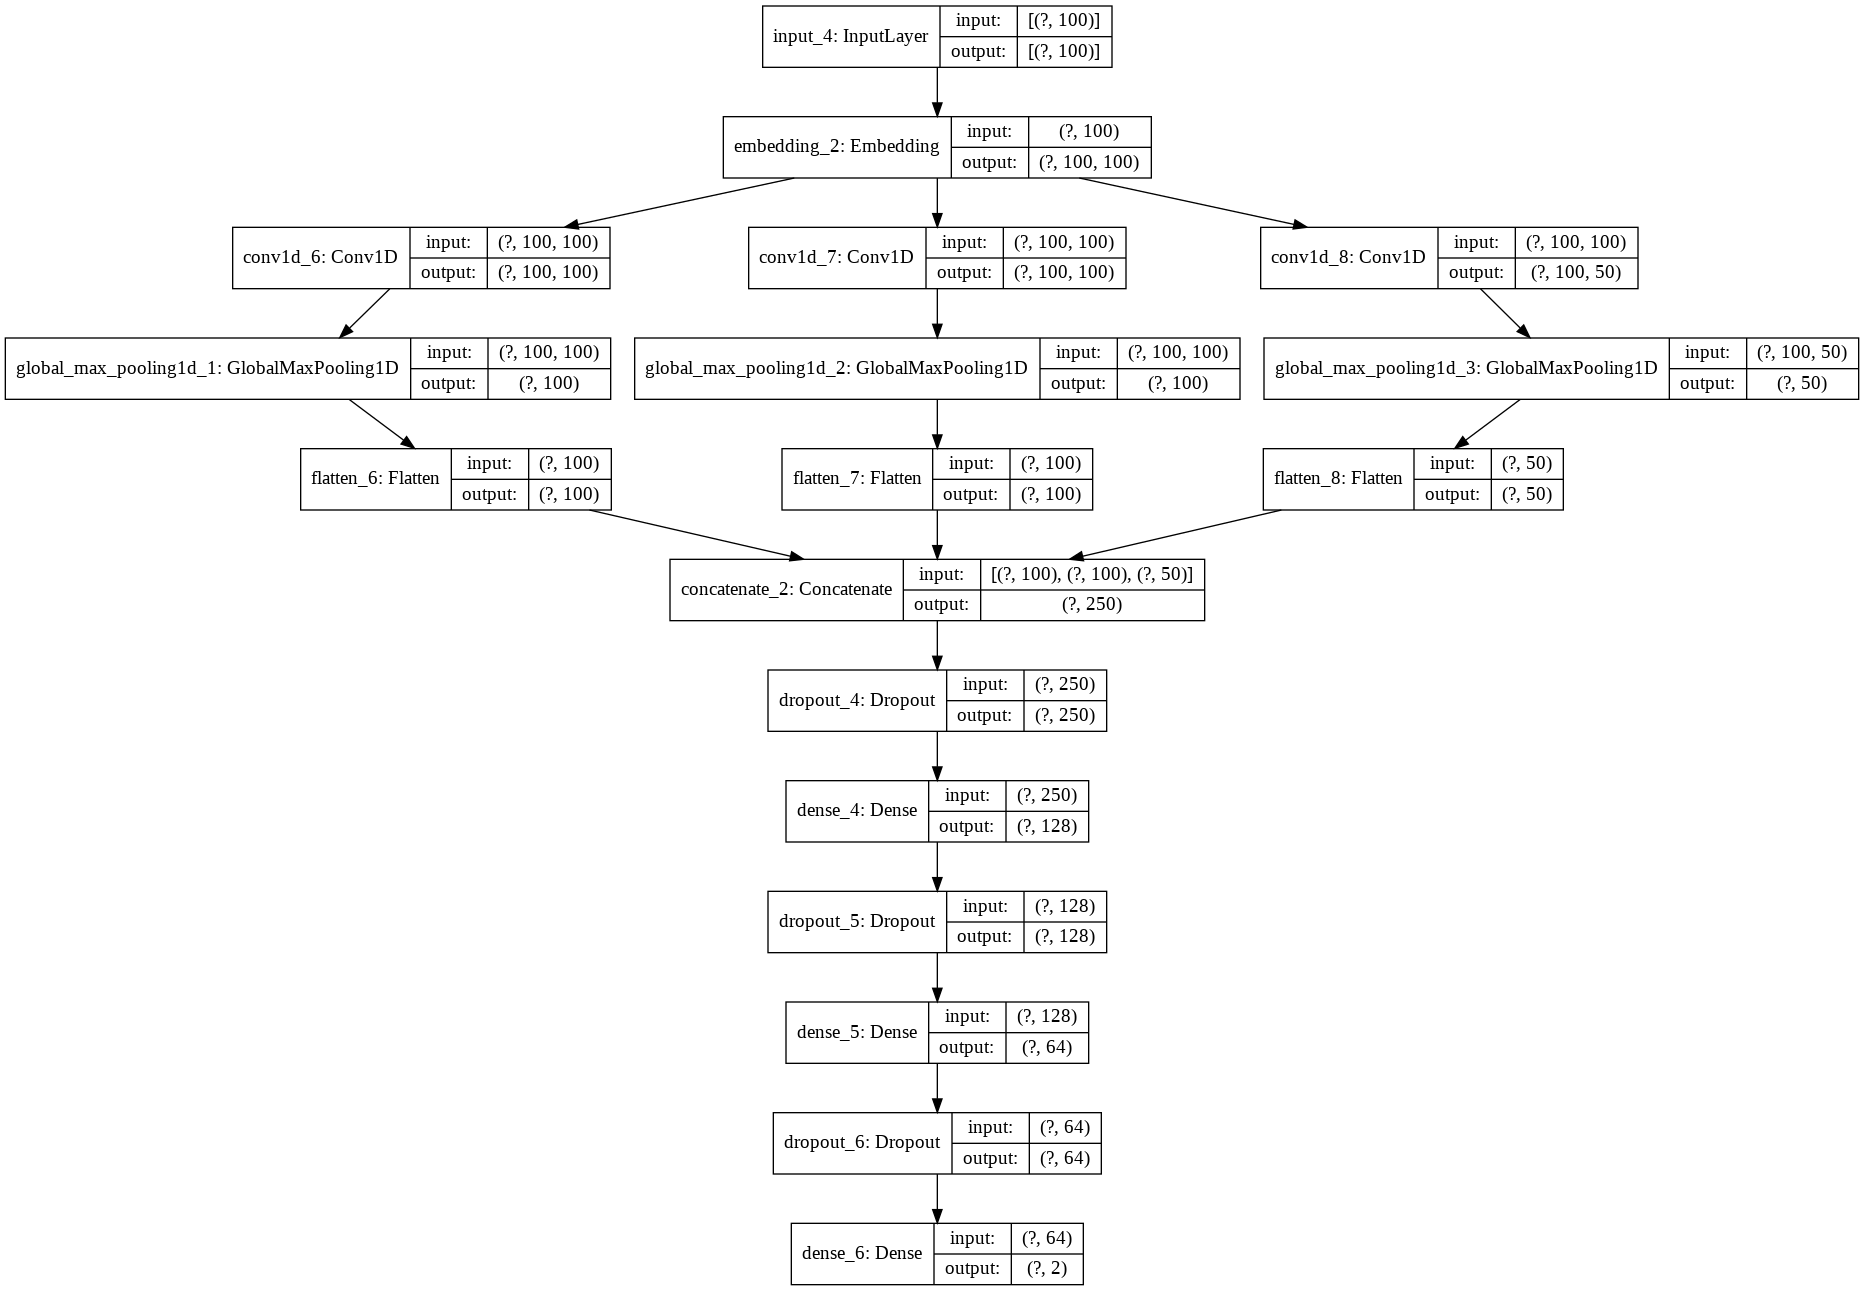

In [30]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model



Split the data into train and test

In [17]:
# Define a size for train set
train_size = int(0.5 * len(X))
# Split dataset 
train_X = X[:train_size]
test_X = X[train_size:]
train_Y = Y[:train_size]
test_Y = Y[train_size:]

Start training

In [31]:
batch_size = 32
model.fit(train_X,train_Y, epochs = 12, batch_size=batch_size,validation_data=(test_X,test_Y))


Epoch 1/12
25000/25000 [==============================] - 2457s 98ms/step - loss: 0.4296 - accuracy: 0.8038 - val_loss: 0.3986 - val_accuracy: 0.8213
Epoch 2/12
25000/25000 [==============================] - 2507s 100ms/step - loss: 0.3623 - accuracy: 0.8437 - val_loss: 0.3968 - val_accuracy: 0.8222
Epoch 3/12
 7190/25000 [=======>......................] - ETA: 28:59 - loss: 0.2977 - accuracy: 0.8770Buffered data was truncated after reaching the output size limit.

Test the model on a validation set

In [32]:
validation_size = 10000
X_validate = test_X[-validation_size:]
Y_validate = test_Y[-validation_size:]
# X_test = X_test[:-validation_size]
# Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(x=test_X,y= np.array(test_Y), batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

25000/25000 [==============================] - 57s 2ms/step - loss: 0.4826 - accuracy: 0.8017
score: 0.48
acc: 0.80


Function to make predictions

In [37]:
def guess(twt):
    #vectorizing the tweet by the pre-fitted tokenizer instance
    twt = [twt]
    twt = tokenizer.texts_to_sequences(twt)
    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=seq_length, dtype='int32', value=0)
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
    #print(sentiment)
    print("Confidence: " + str(sentiment[np.argmax(sentiment)]*100) + "%")
    if(np.argmax(sentiment) == 0):
        print("negative")
    elif (np.argmax(sentiment) == 1):
        print("positive")
    elif (np.argmax(sentiment) == 2):
        print("neutral")


In [82]:
def raw_predictions(text):
  print(text)
  x = model.predict(pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=seq_length, dtype='int32', value=0),batch_size=1,verbose = 2)
  return x,text

In [106]:
guess("LA is one of my least favorite cities")

1/1 - 0s
Confidence: 84.66942310333252%
negative


In [100]:
raw_predictions(data["Text"][10098])

packing my bag about to head to maryland 
1/1 - 0s


(array([[0.32822135, 0.6717786 ]], dtype=float32),
 'packing my bag about to head to maryland ')

In [99]:
data["Target"].values[10098]

4

In [ ]:
data["Text"].values[6419]

'i need work bad im in a lowkey depression right now pray for me '

In [33]:
Y[6419]

0.0

In [40]:
model.save("model.h5")